In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd

In [2]:
def load_data_for_analysis(tickers, folder_path):

    df_all = []

    for ticker in tickers:
        file_path = os.path.join(folder_path, f"{ticker}.xlsx")
        if os.path.exists(file_path):
            df = pd.read_excel(file_path)
            df["ticker"] = ticker  # thêm cột ticker
            df_all.append(df)
        else:
            print(f"⚠️ Không tìm thấy: {file_path}")

    # Gộp lại thành 1 DataFrame
    df_global = pd.concat(df_all, ignore_index=True)
    print(f"✅ Đã load xong {len(df_global)} dòng dữ liệu từ {len(df_all)} cổ phiếu.")
    return df_global

In [3]:
tickers = ['ACB', 'BCM', 'BID','BVH','CTG','FPT','GAS','GVR','HDB','HPG',
                    'LPB','MBB','MSN','MWG','PLX','SAB','SHB','SSB','SSI','STB',
                    'TCB','TPB','VCB','VHM','VIB','VIC','VJC','VNM','VPB','VRE']
folder_path_train = r"D:\thacsi\TAILIEULUANVAN\code\PredictStock_TA_FA_SA\TA_FA_SA\data\v5\out_performance_vn30\train_data" 
folder_path_test = r"D:\thacsi\TAILIEULUANVAN\code\PredictStock_TA_FA_SA\TA_FA_SA\data\v5\out_performance_vn30\test_data" 
df_global_train = load_data_for_analysis(tickers, folder_path_train)
df_global_test = load_data_for_analysis(tickers, folder_path_test)


✅ Đã load xong 35928 dòng dữ liệu từ 30 cổ phiếu.
✅ Đã load xong 7380 dòng dữ liệu từ 30 cổ phiếu.


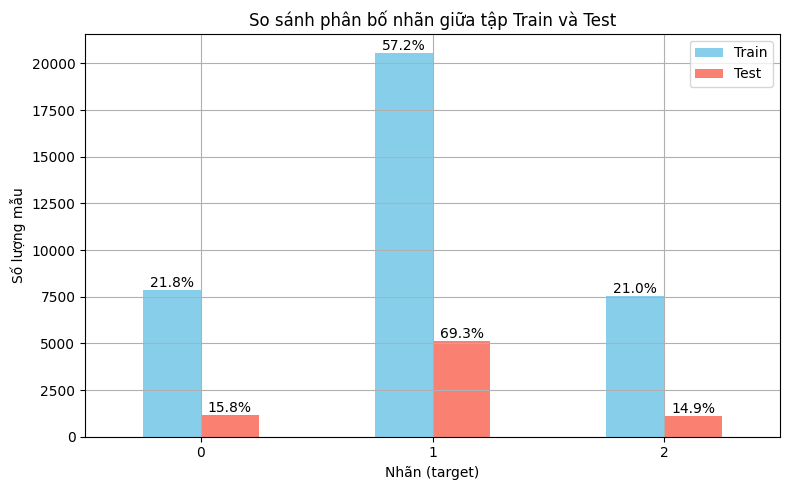

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Đếm số lượng mẫu theo nhãn
train_counts = df_global_train['target'].value_counts().sort_index()
test_counts = df_global_test['target'].value_counts().sort_index()

# Tính tổng để tính tỷ lệ %
train_total = train_counts.sum()
test_total = test_counts.sum()

# Tạo DataFrame chứa cả số lượng và tỷ lệ %
distribution_df = pd.DataFrame({
    'Train': train_counts,
    'Test': test_counts
})

# Vẽ biểu đồ
ax = distribution_df.plot(kind='bar', figsize=(8, 5), color=['skyblue', 'salmon'])
plt.title('So sánh phân bố nhãn giữa tập Train và Test')
plt.xlabel('Nhãn (target)')
plt.ylabel('Số lượng mẫu')
plt.grid(True)
plt.xticks(rotation=0)

# Hiển thị tỷ lệ phần trăm trên đầu cột
for i, container in enumerate(ax.containers):
    total = train_total if i == 0 else test_total
    for bar in container:
        height = bar.get_height()
        percent = height / total * 100
        ax.text(bar.get_x() + bar.get_width()/2, height + 1,
                f'{percent:.1f}%', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


In [6]:
sentiment_columns = [
        'Reputation', 'Company Communication', 'Appointment', 'Financial', 'Regulatory',
        'Sales', 'M&A', 'Legal', 'Dividend Policy', 'Risks', 'Rumors', 'Strategy',
        'Options', 'IPO', 'Signal', 'Coverage', 'Fundamentals', 'Insider Activity',
        'Price Action', 'Buyside', 'Technical Analysis', 'Trade', 'Central Banks',
        'Currency', 'Conditions', 'Market', 'Volatility', 'Investor Sentiment', 'Retail Investor Behavior',
        'Speculation', 'Domestic Institutional Behavior', 'Foreign Institutional Behavior', 'Black Swan Event',
    ]

sentiment_p1d_columns = [
        'reputation_p1d', 'company_communication_p1d', 'appointment_p1d', 'financial_p1d', 'regulatory_p1d',
        'sales_p1d', 'm&a_p1d', 'legal_p1d', 'dividend_policy_p1d', 'risks_p1d', 'rumors_p1d', 'strategy_p1d',
        'options_p1d', 'ipo_p1d', 'signal_p1d', 'coverage_p1d', 'fundamentals_p1d', 'insider_activity_p1d',
        'price_action_p1d', 'buyside_p1d', 'technical_analysis_p1d', 'trade_p1d', 'central_banks_p1d',
        'currency_p1d', 'conditions_p1d', 'market_p1d', 'volatility_p1d', 'investor_sentiment_p1d', 'retail_investor_behavior_p1d',
        'speculation_p1d', 'domestic_institutional_behavior_p1d', 'foreign_institutional_behavior_p1d', 'black_swan_event_p1d',
    ]
meta_cols = ['num_sa_news', 'mean_sentiment_norm', 'max_sentiment_norm', 'std_sentiment_score', 'sum_positive_sa', 'sum_negative_sa', 'time_distance_from_sa_to_close_minutes']
meta_p1d_cols = ['num_sa_news_p1d', 'mean_sentiment_norm_p1d', 'max_sentiment_norm_p1d', 'std_sentiment_score_p1d', 'sum_positive_sa_p1d', 'sum_negative_sa_p1d', 'time_distance_from_sa_to_close_minutes_p1d']

sentiment_features = sentiment_columns + sentiment_p1d_columns + meta_cols + meta_p1d_cols

target = ['target']



📊 Train: 15642/35928 có SA (43.54%)
📊 Test:  2628/7380 có SA (35.61%)


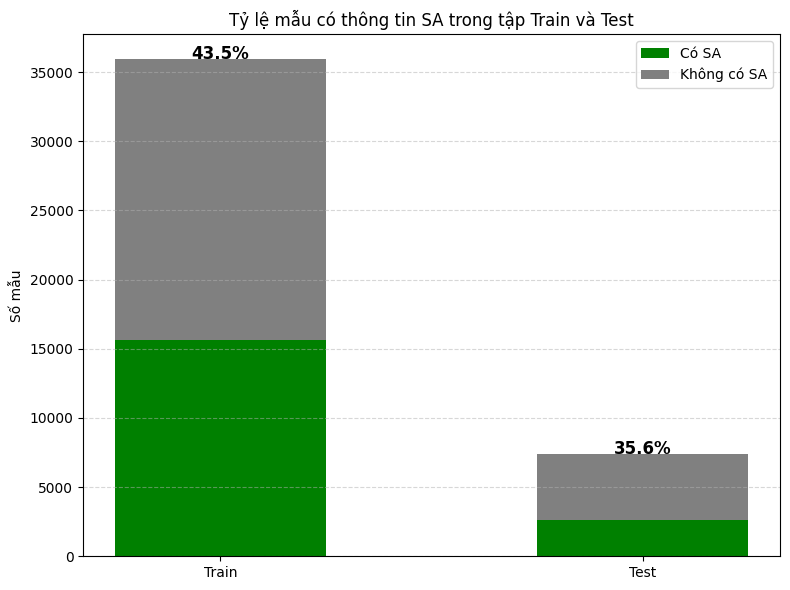

In [7]:
def compute_sa_ratio(df, sentiment_columns):
    has_sa = (df[sentiment_columns].abs().sum(axis=1) != 0)
    ratio = has_sa.sum() / len(df)
    return has_sa.sum(), len(df), ratio

# Tính cho train và test
n_train_sa, n_train_total, ratio_train = compute_sa_ratio(df_global_train, sentiment_features)
n_test_sa, n_test_total, ratio_test = compute_sa_ratio(df_global_test, sentiment_features)

print(f"📊 Train: {n_train_sa}/{n_train_total} có SA ({ratio_train:.2%})")
print(f"📊 Test:  {n_test_sa}/{n_test_total} có SA ({ratio_test:.2%})")
# Dữ liệu
labels = ['Train', 'Test']
values_with_sa = [n_train_sa, n_test_sa]
values_without_sa = [n_train_total - n_train_sa, n_test_total - n_test_sa]

bar_width = 0.5
bar1 = [0, 1]  # vị trí trên trục x

# Vẽ stacked bar chart
plt.figure(figsize=(8, 6))
plt.bar(bar1, values_with_sa, bar_width, label='Có SA', color='green')
plt.bar(bar1, values_without_sa, bar_width, bottom=values_with_sa, label='Không có SA', color='gray')

plt.xticks(bar1, labels)
plt.ylabel("Số mẫu")
plt.title("Tỷ lệ mẫu có thông tin SA trong tập Train và Test")
plt.legend(loc='upper right')
plt.tight_layout()
plt.grid(True, axis='y', linestyle='--', alpha=0.5)

# Hiển thị giá trị phần trăm ngay trên cột
for i in range(len(bar1)):
    total = values_with_sa[i] + values_without_sa[i]
    plt.text(bar1[i], total + 5, f"{(values_with_sa[i]/total)*100:.1f}%", ha='center', fontsize=12, fontweight='bold')

plt.show()

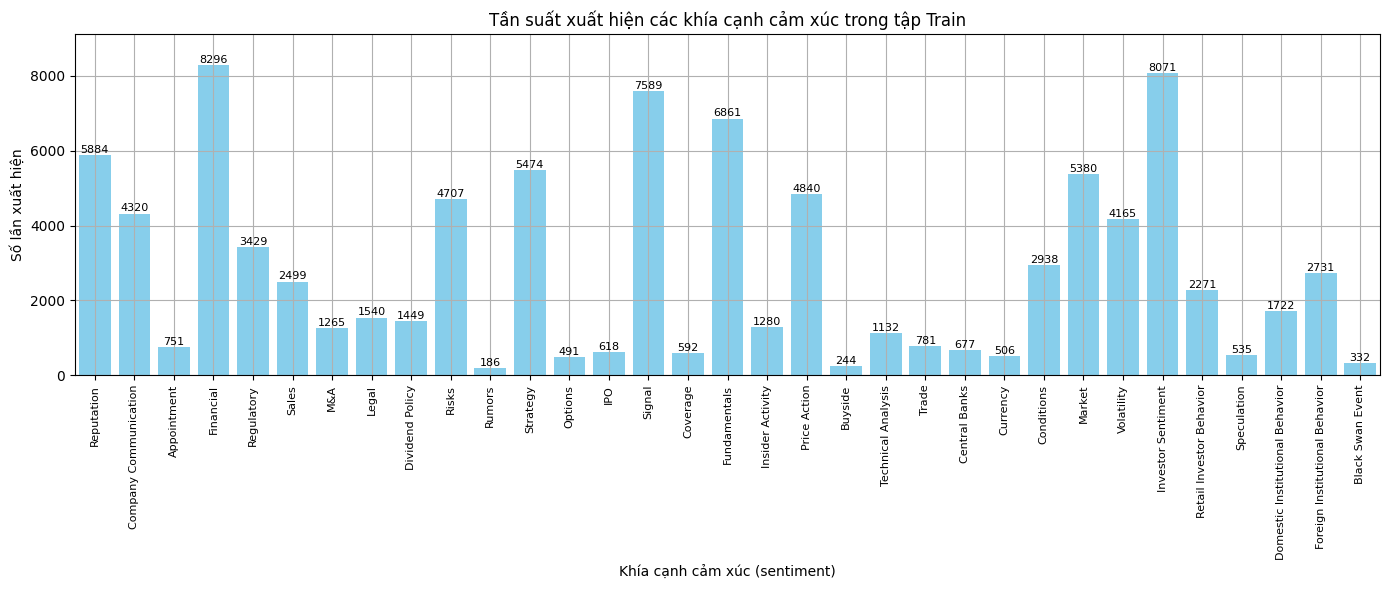

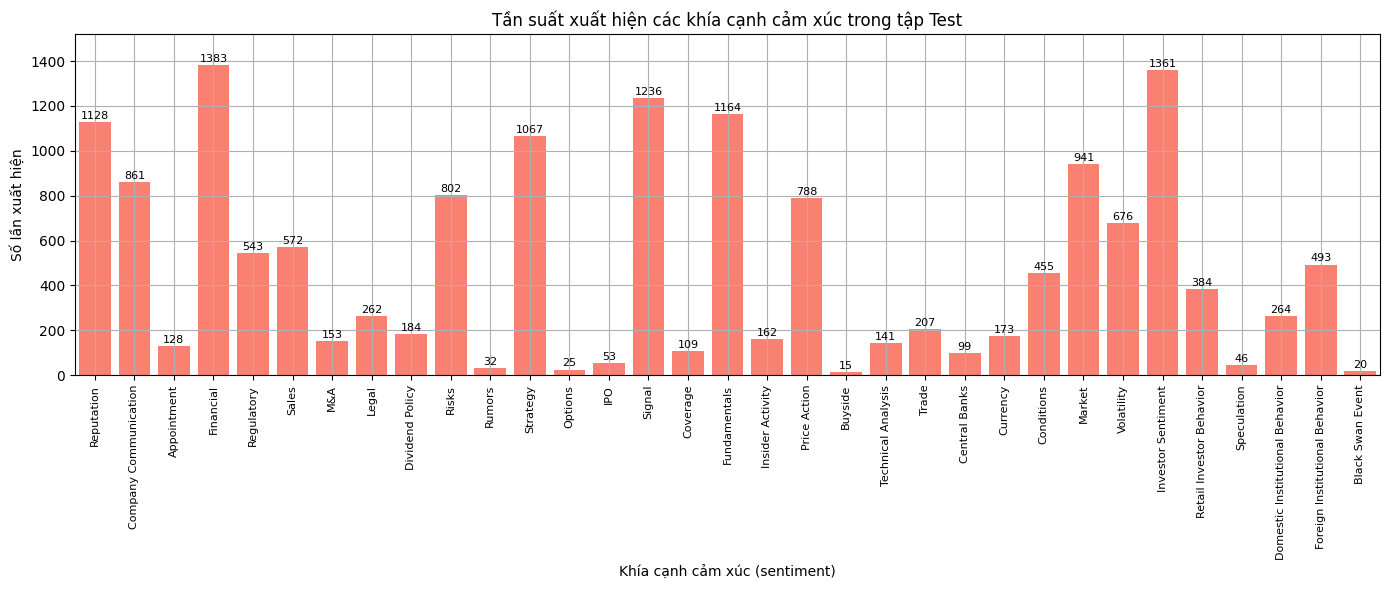

In [8]:
# common_index = train_counts.index.intersection(test_counts.index)
train_counts = (df_global_train[sentiment_columns] != 0).sum()
test_counts = (df_global_test[sentiment_columns] != 0).sum()

plt.figure(figsize=(14, 6))
train_counts.plot(kind='bar', width=0.8, color='skyblue')
plt.title('Tần suất xuất hiện các khía cạnh cảm xúc trong tập Train')
plt.xlabel('Khía cạnh cảm xúc (sentiment)')
plt.ylabel('Số lần xuất hiện')
plt.xticks(rotation=90, fontsize=8)
plt.xlim(-0.5, len(train_counts)-0.5)
plt.ylim(0, max(train_counts)*1.1)
plt.grid(True)

for i, value in enumerate(train_counts):
    plt.text(i, value + 5, str(value), ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 6))
test_counts.plot(kind='bar', width=0.8, color='salmon')
plt.title('Tần suất xuất hiện các khía cạnh cảm xúc trong tập Test')
plt.xlabel('Khía cạnh cảm xúc (sentiment)')
plt.ylabel('Số lần xuất hiện')
plt.xticks(rotation=90, fontsize=8)
plt.xlim(-0.5, len(test_counts)-0.5)
plt.ylim(0, max(test_counts)*1.1)
plt.grid(True)

for i, value in enumerate(test_counts):
    plt.text(i, value + 5, str(value), ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()


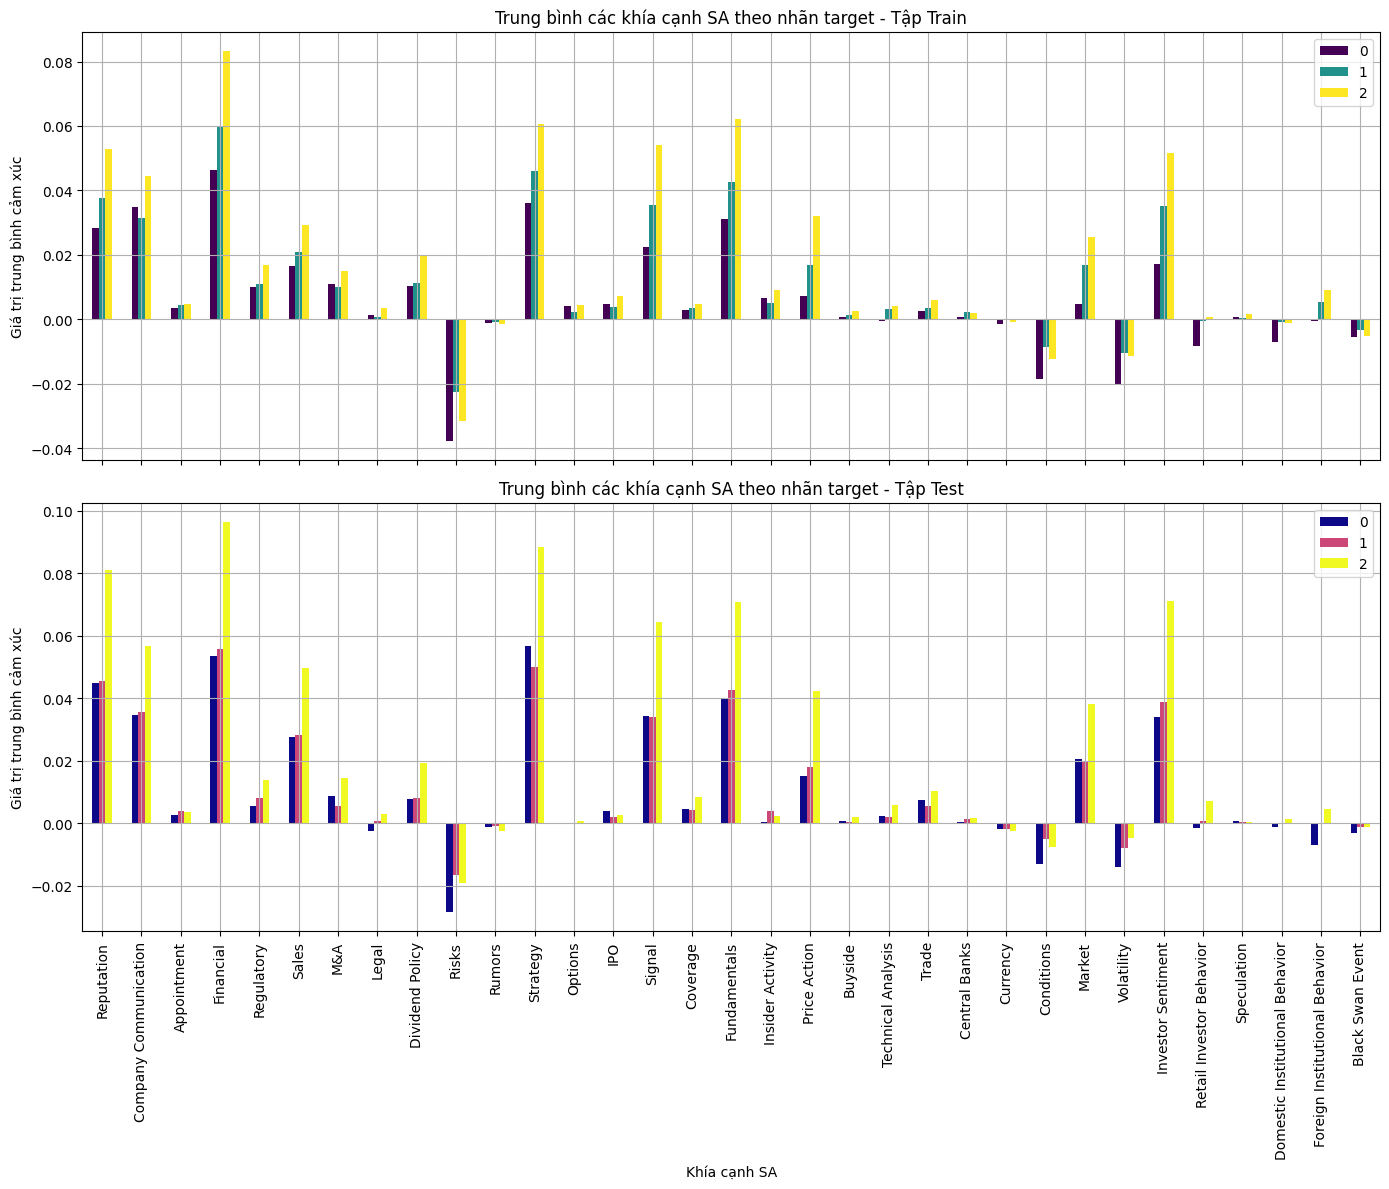

In [9]:
# Tính trung bình cảm xúc theo target
grouped_means_train = df_global_train.groupby('target')[sentiment_columns].mean()
grouped_means_test = df_global_test.groupby('target')[sentiment_columns].mean()

# Vẽ biểu đồ dạng subplot
fig, axes = plt.subplots(2, 1, figsize=(14, 12), sharex=True)

# Biểu đồ tập train
grouped_means_train.T.plot(kind='bar', ax=axes[0], colormap='viridis')
axes[0].set_title("Trung bình các khía cạnh SA theo nhãn target - Tập Train")
axes[0].set_ylabel("Giá trị trung bình cảm xúc")
axes[0].grid(True)
axes[0].legend(loc='upper right')

# Biểu đồ tập test
grouped_means_test.T.plot(kind='bar', ax=axes[1], colormap='plasma')
axes[1].set_title("Trung bình các khía cạnh SA theo nhãn target - Tập Test")
axes[1].set_ylabel("Giá trị trung bình cảm xúc")
axes[1].set_xlabel("Khía cạnh SA")
axes[1].grid(True)
axes[1].legend(loc='upper right')

plt.tight_layout()
plt.show()

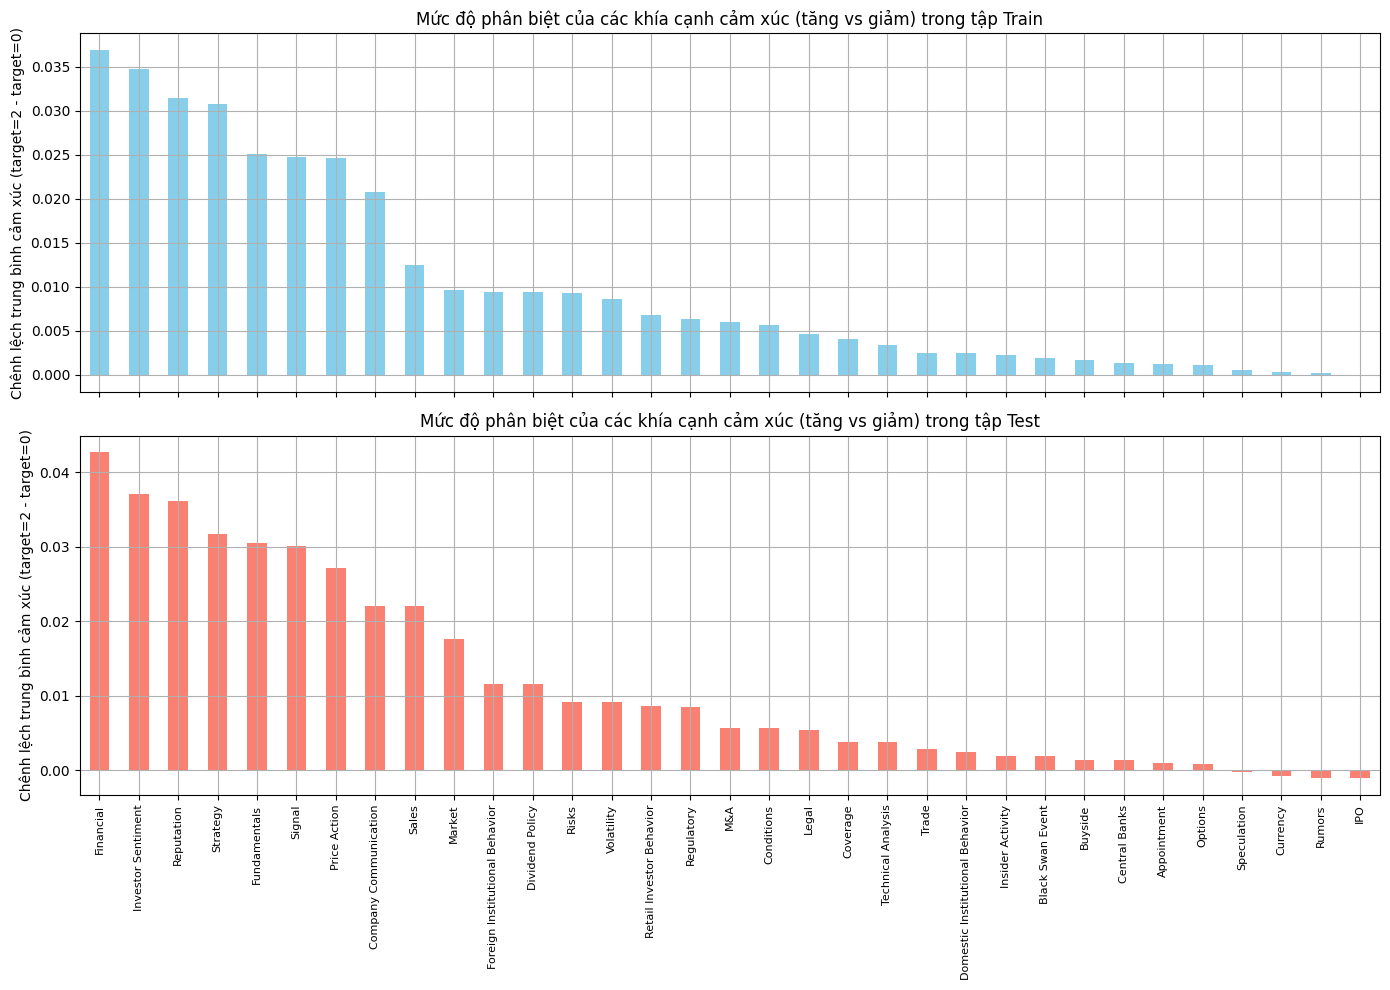

In [10]:
import matplotlib.pyplot as plt

diff_train = grouped_means_train.loc[2] - grouped_means_train.loc[0]
diff_test = grouped_means_test.loc[2] - grouped_means_test.loc[0]

fig, axs = plt.subplots(2, 1, figsize=(14, 10), sharex=True)  # 2 hàng, 1 cột, cùng trục x

# Biểu đồ trên (train)
diff_train.sort_values(ascending=False).plot(kind='bar', color='skyblue', ax=axs[0])
axs[0].set_title("Mức độ phân biệt của các khía cạnh cảm xúc (tăng vs giảm) trong tập Train")
axs[0].set_ylabel("Chênh lệch trung bình cảm xúc (target=2 - target=0)")
axs[0].grid(True)

# Biểu đồ dưới (test)
diff_test.sort_values(ascending=False).plot(kind='bar', color='salmon', ax=axs[1])
axs[1].set_title("Mức độ phân biệt của các khía cạnh cảm xúc (tăng vs giảm) trong tập Test")
axs[1].set_ylabel("Chênh lệch trung bình cảm xúc (target=2 - target=0)")
axs[1].grid(True)

plt.xticks(rotation=90, fontsize=8)
plt.tight_layout()
plt.show()


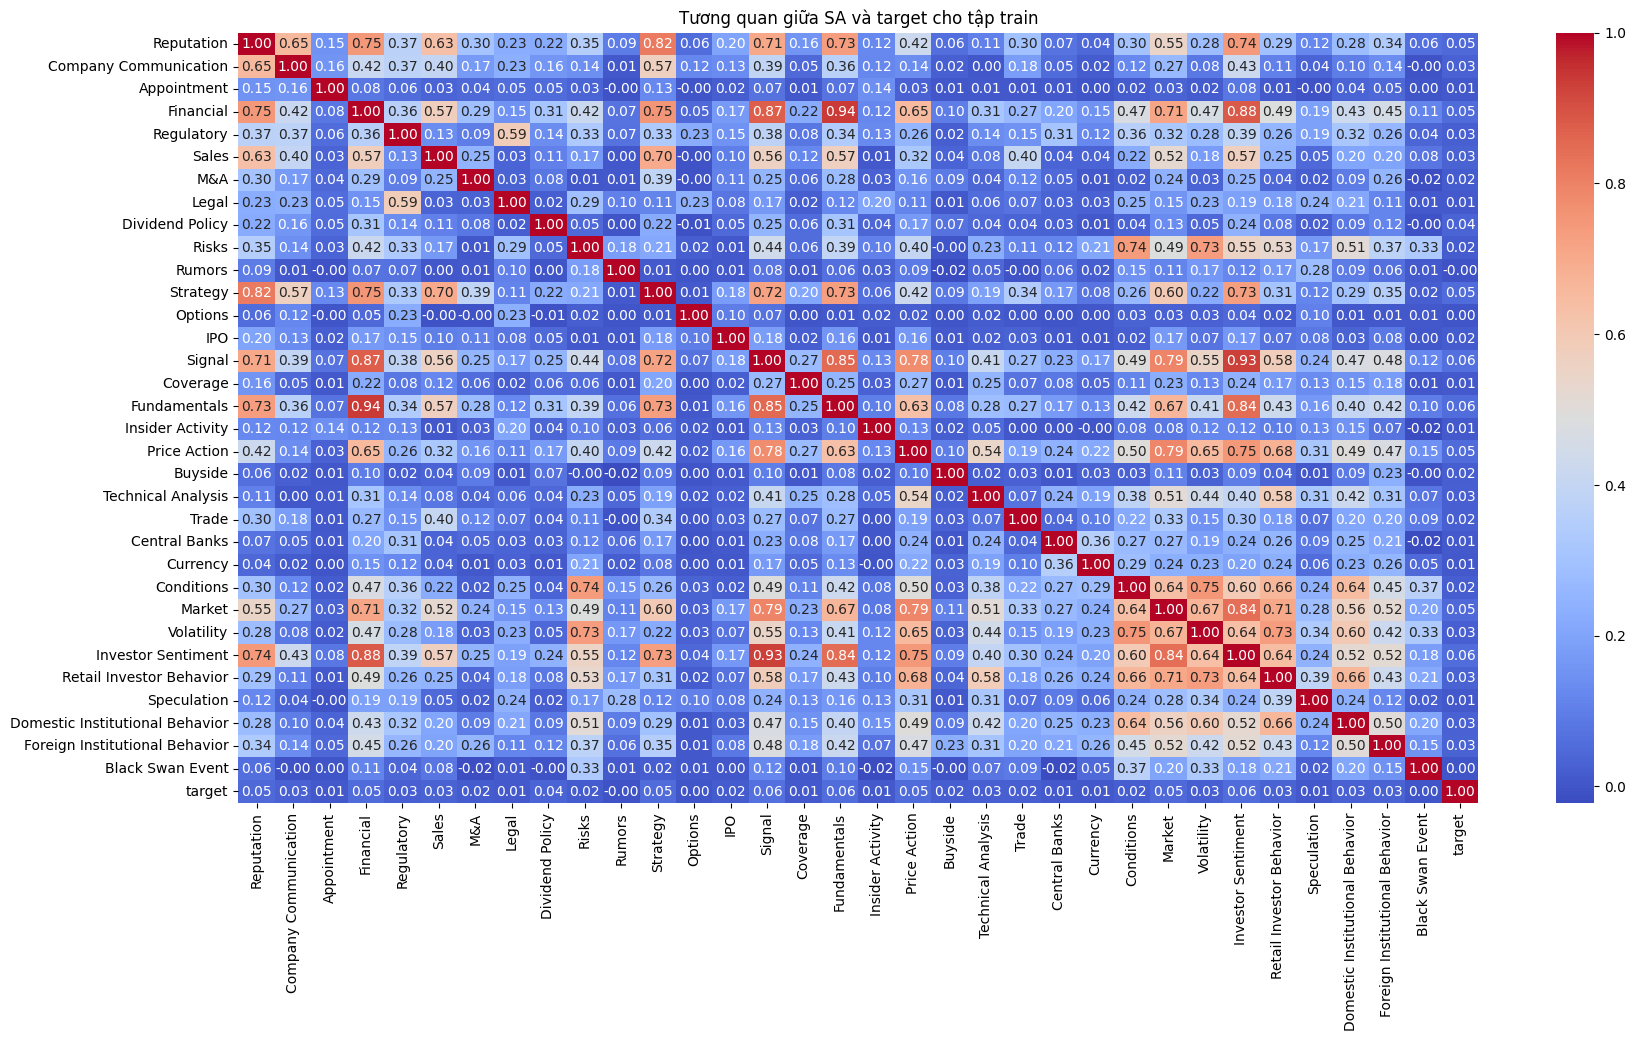

In [11]:
# Nếu target là phân loại, cần chuyển sang số
corr_matrix = df_global_train[sentiment_columns + ['target']].corr()
plt.figure(figsize=(20, 10))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Tương quan giữa SA và target cho tập train")
plt.show()

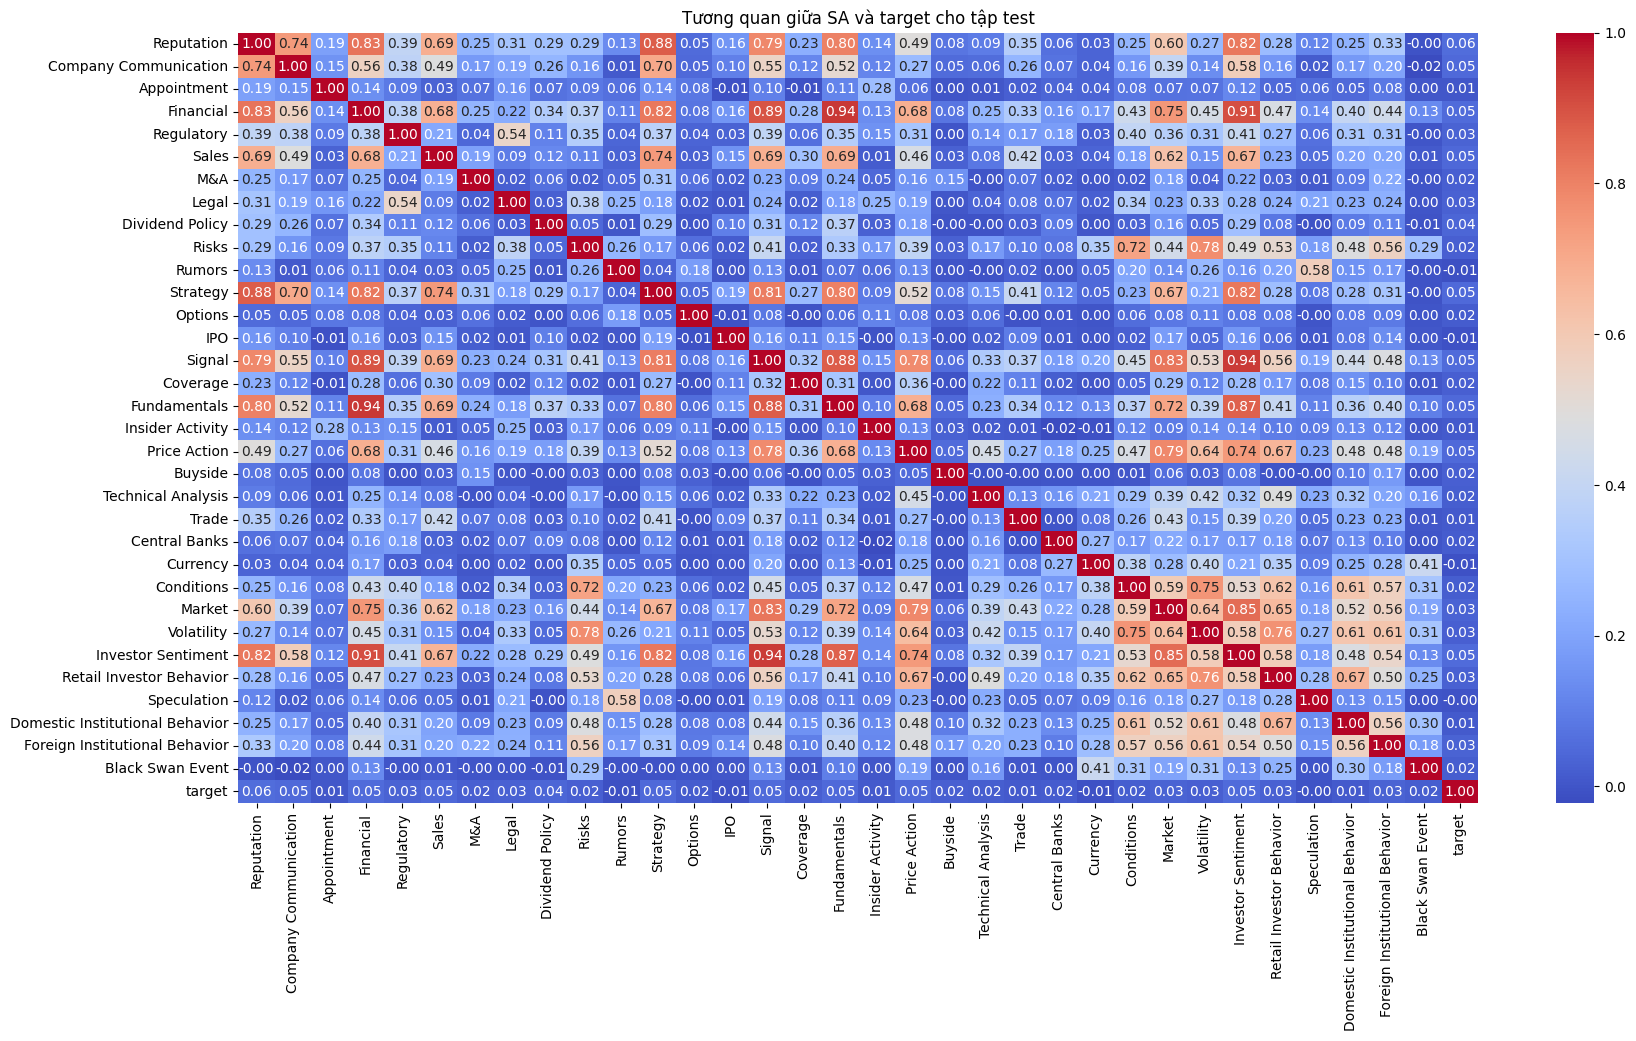

In [12]:
# Nếu target là phân loại, cần chuyển sang số
corr_matrix = df_global_test[sentiment_columns + ['target']].corr()
plt.figure(figsize=(20, 10))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Tương quan giữa SA và target cho tập test")
plt.show()